<a href="https://colab.research.google.com/github/mmehmetaliyavuz/cellrecognation/blob/main/cellrecognation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"We used image set BBBC041v1, available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]."



In [1]:
!wget https://data.broadinstitute.org/bbbc/BBBC041/malaria.zip

--2024-03-18 18:12:34--  https://data.broadinstitute.org/bbbc/BBBC041/malaria.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.68.137
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.68.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2259224287 (2.1G) [application/zip]
Saving to: ‘malaria.zip’

malaria.zip         100%[===================>]   2.10G  42.9MB/s    in 50s     

2024-03-18 18:13:24 (43.5 MB/s) - ‘malaria.zip’ saved [2259224287/2259224287]



In [2]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.2 MB/s eta 0:00:00


In [3]:
import zipfile
def unzip_file(path):
  with zipfile.ZipFile(path,"r") as zipfil:
    zipfil.extractall()

In [4]:
unzip_file("/content/malaria.zip")

In [5]:
import json
file_path = '/content/malaria/test.json'

with open(file_path, 'r') as file:
    data = json.load(file)

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import json
import keras_cv
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend


In [34]:
LEARNING_RATE = 0.001
EPOCH = 25
GLOBAL_CLIPNORM = 10.0

In [23]:

def data_loader(path):
  file_path = path

  with open(file_path, 'r') as file:
    data = json.load(file)

  all_bounding_boxes = []  # Tüm bounding box bilgilerini tutmak için boş bir liste oluşturuyoruz

  for image_data in data:
      image_path = image_data['image']['pathname']
      image_boxes = []  # Her bir fotoğraf için tüm bounding box bilgilerini içeren bir alt liste oluşturuyoruz

      for obj in image_data['objects']:
          bounding_box = obj['bounding_box']
          minimum = bounding_box['minimum']
          maximum = bounding_box['maximum']
          xmin, ymin = minimum['c'], minimum['r']
          xmax, ymax = maximum['c'], maximum['r']
          category = obj['category']

          # Her bir bounding box bilgisini alt liste olarak ekliyoruz
          image_boxes.append({
              'xmin': xmin,
              'ymin': ymin,
              'xmax': xmax,
              'ymax': ymax,
              'category': category
          })

      # Tüm bounding box bilgilerini içeren alt listeyi ana liste içine ekliyoruz
      all_bounding_boxes.append({
          'pathname': image_path,
          'bounding_boxes': image_boxes
      })
  paths = []
  bboxes = []
  classes = []

  for image_data in all_bounding_boxes:
      pathname = image_data['pathname']
      image_bboxes = []
      image_classes = []

      for bbox_info in image_data['bounding_boxes']:
          xmin = bbox_info['xmin']
          ymin = bbox_info['ymin']
          xmax = bbox_info['xmax']
          ymax = bbox_info['ymax']
          category = bbox_info['category']

          image_bboxes.append([xmin, ymin, xmax, ymax])
          image_classes.append(category)

      paths.append(pathname)
      bboxes.append(image_bboxes)
      classes.append(image_classes)
  all_classes = [item for sublist in classes for item in sublist]

  label_encoder = LabelEncoder()
  encoded_all_classes = label_encoder.fit_transform(all_classes)

  start_index = 0
  encoded_classes_list = []
  for sublist in classes:
    sublist_length = len(sublist)
    encoded_sublist = encoded_all_classes[start_index:start_index+sublist_length]
    encoded_classes_list.append(encoded_sublist)
    start_index += sublist_length
  paths = [f"/content/malaria"+path for path in paths]
  def ragger(arg):
    return tf.ragged.constant(arg)
  return ragger(paths), ragger(bboxes), ragger(encoded_classes_list)


In [24]:
train_paths,train_bboxes,train_classes=data_loader("/content/malaria/training.json")
test_paths,test_bboxes,test_classes=data_loader("/content/malaria/test.json")


In [ ]:
test_paths,test_bboxes,test_classes

In [26]:
class_mapping = {1:"gametocyte",0:"difficult",2:"leukocyte",3:"red blood cell",6:"trophozoite",5:"schizont",4:"ring",}

In [27]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img,channels = 3)
    img = tf.cast(img, tf.float32)
    return img
jittered_resize = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy",
)

def handler(img_paths, bbox, classes):
    image = load_image(img_paths)
    bboxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox}

    return {"images": image, "bounding_boxes": bboxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [28]:
train = tf.data.Dataset.from_tensor_slices((train_paths,train_bboxes,train_classes))
train_data = (train
             .map(handler, num_parallel_calls=tf.data.AUTOTUNE)
             .shuffle(40)
             .ragged_batch(4, drop_remainder=True)
             .map(jittered_resize, num_parallel_calls=tf.data.AUTOTUNE)
             .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
             .prefetch(tf.data.AUTOTUNE))
test = tf.data.Dataset.from_tensor_slices((test_paths,test_bboxes,test_classes))
test_data = (test
             .map(handler, num_parallel_calls=tf.data.AUTOTUNE)
             .shuffle(40)
             .ragged_batch(4, drop_remainder=True)
             .map(jittered_resize, num_parallel_calls=tf.data.AUTOTUNE)
             .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
             .prefetch(tf.data.AUTOTUNE))

In [29]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 6,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

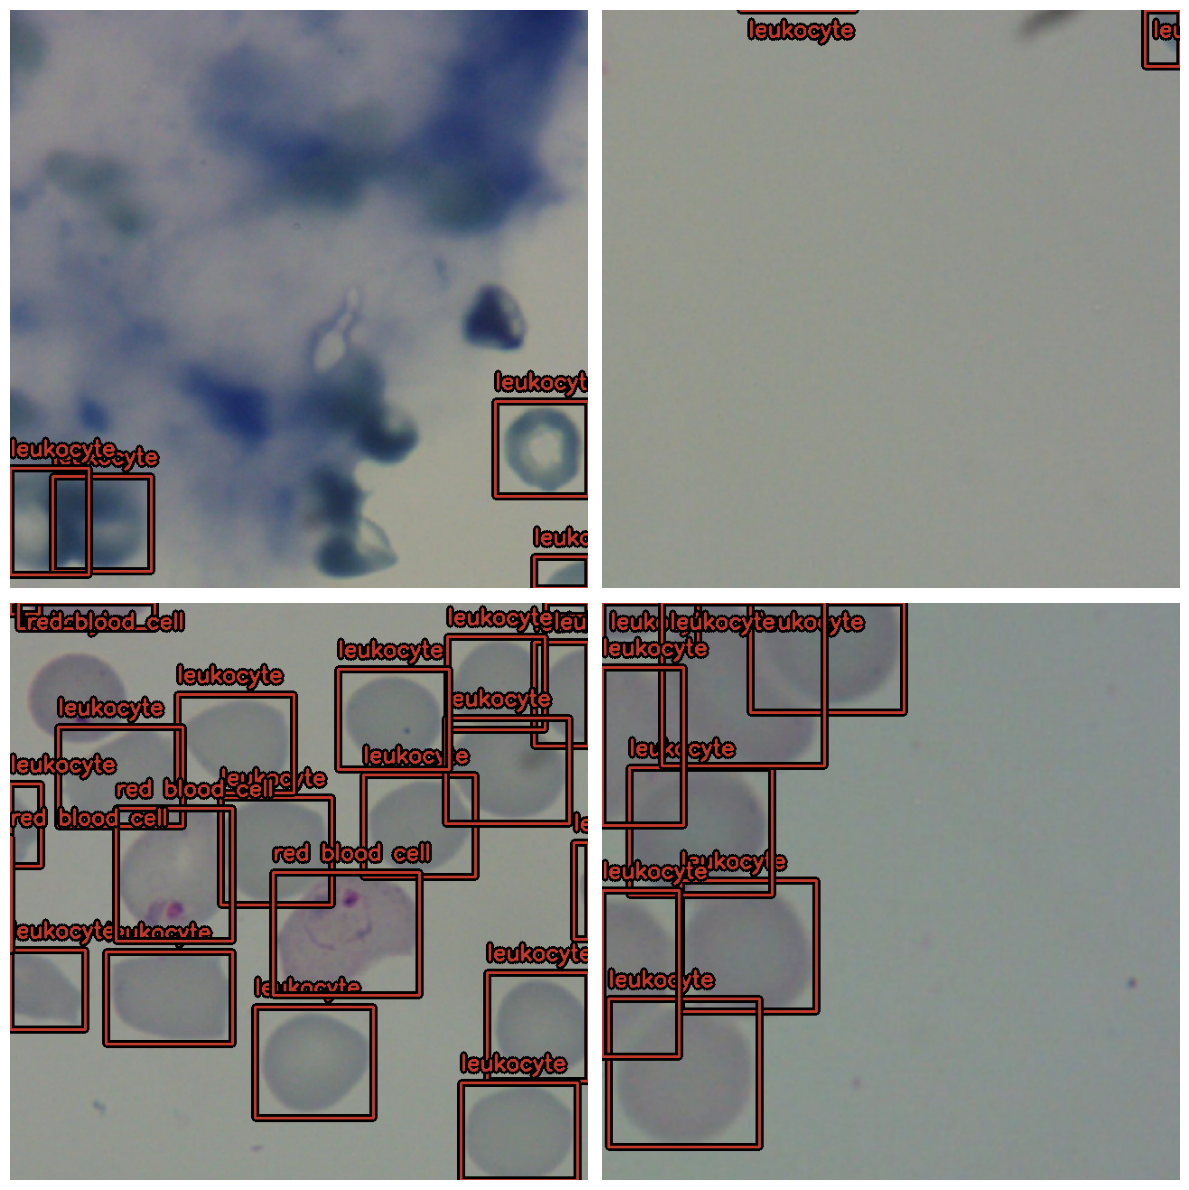

In [30]:
visualize_dataset(test_data, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

In [36]:
stg = tf.distribute.MultiWorkerMirroredStrategy()

In [38]:
with stg.scope():
  basemodel = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling = True)
  yoloV8 = keras_cv.models.YOLOV8Detector(
      num_classes=len(class_mapping),
      bounding_box_format="xyxy",
      backbone=basemodel,
      fpn_depth=1,
  )
  optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)
  yoloV8.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [40]:
yoloV8.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCH,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("/content/yoloV8model",monitor="val_loss",save_best_only=True)],
)

Epoch 1/25
302/302 [==============================] - ETA: 0s - loss: 9.9383 - box_loss: 1.5868 - class_loss: 8.3515

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:4

302/302 [==============================] - 325s 667ms/step - loss: 9.9383 - box_loss: 1.5868 - class_loss: 8.3515 - val_loss: 3.5890 - val_box_loss: 1.9829 - val_class_loss: 1.6061
Epoch 2/25
302/302 [==============================] - ETA: 0s - loss: 1.5033 - box_loss: 1.0919 - class_loss: 0.4114

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:4

302/302 [==============================] - 205s 669ms/step - loss: 1.5033 - box_loss: 1.0919 - class_loss: 0.4114 - val_loss: 2.0416 - val_box_loss: 1.3981 - val_class_loss: 0.6435
Epoch 3/25
302/302 [==============================] - ETA: 0s - loss: 1.1812 - box_loss: 0.9868 - class_loss: 0.1943

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:4

302/302 [==============================] - 201s 659ms/step - loss: 1.1812 - box_loss: 0.9868 - class_loss: 0.1943 - val_loss: 1.8829 - val_box_loss: 1.3281 - val_class_loss: 0.5548
Epoch 4/25
302/302 [==============================] - ETA: 0s - loss: 1.1087 - box_loss: 0.9639 - class_loss: 0.1449

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:4

302/302 [==============================] - 208s 678ms/step - loss: 1.1087 - box_loss: 0.9639 - class_loss: 0.1449 - val_loss: 1.8165 - val_box_loss: 1.2846 - val_class_loss: 0.5319
Epoch 5/25
302/302 [==============================] - ETA: 0s - loss: 1.0477 - box_loss: 0.9281 - class_loss: 0.1196

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:4

302/302 [==============================] - 191s 625ms/step - loss: 1.0477 - box_loss: 0.9281 - class_loss: 0.1196 - val_loss: 1.8070 - val_box_loss: 1.2020 - val_class_loss: 0.6049
Epoch 6/25
302/302 [==============================] - ETA: 0s - loss: 1.0193 - box_loss: 0.9112 - class_loss: 0.1081

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:4

302/302 [==============================] - 194s 630ms/step - loss: 1.0193 - box_loss: 0.9112 - class_loss: 0.1081 - val_loss: 1.7164 - val_box_loss: 1.1331 - val_class_loss: 0.5833
Epoch 7/25
302/302 [==============================] - 152s 496ms/step - loss: 0.9904 - box_loss: 0.8916 - class_loss: 0.0987 - val_loss: 1.7708 - val_box_loss: 1.1809 - val_class_loss: 0.5899
Epoch 8/25
302/302 [==============================] - 151s 492ms/step - loss: 0.9806 - box_loss: 0.8876 - class_loss: 0.0930 - val_loss: 1.7177 - val_box_loss: 1.0733 - val_class_loss: 0.6444
Epoch 9/25
302/302 [==============================] - 154s 503ms/step - loss: 0.9550 - box_loss: 0.8680 - class_loss: 0.0870 - val_loss: 1.8119 - val_box_loss: 1.1156 - val_class_loss: 0.6963
Epoch 10/25
302/302 [==============================] - 152s 495ms/step - loss: 0.9416 - box_loss: 0.8585 - class_loss: 0.0831 - val_loss: 1.8225 - val_box_loss: 1.1268 - val_class_loss: 0.6958
Epoch 11/25
302/302 [=============================

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:4

302/302 [==============================] - 192s 629ms/step - loss: 0.9095 - box_loss: 0.8339 - class_loss: 0.0755 - val_loss: 1.6889 - val_box_loss: 0.9921 - val_class_loss: 0.6968
Epoch 15/25
302/302 [==============================] - 153s 499ms/step - loss: 0.9113 - box_loss: 0.8363 - class_loss: 0.0750 - val_loss: 1.7649 - val_box_loss: 1.0682 - val_class_loss: 0.6967
Epoch 16/25
302/302 [==============================] - 156s 506ms/step - loss: 0.9124 - box_loss: 0.8386 - class_loss: 0.0738 - val_loss: 1.7947 - val_box_loss: 1.0844 - val_class_loss: 0.7102
Epoch 17/25
302/302 [==============================] - 159s 518ms/step - loss: 0.8986 - box_loss: 0.8264 - class_loss: 0.0721 - val_loss: 1.9715 - val_box_loss: 1.2441 - val_class_loss: 0.7274
Epoch 18/25
302/302 [==============================] - 155s 508ms/step - loss: 0.9020 - box_loss: 0.8300 - class_loss: 0.0720 - val_loss: 1.8518 - val_box_loss: 1.1059 - val_class_loss: 0.7458
Epoch 19/25
302/302 [==========================

In [41]:
def pred_visualizer(model,data, value_range, rows, cols, bounding_box_format):
  data = next(iter(data.take(1)))
  images, y_test = data[0], data[1]
  y_pred = model.predict(images)
  keras_cv.visualization.plot_bounding_box_gallery(
      images,
      value_range=value_range,
      rows=rows,
      cols=cols,
      y_true=y_pred,
      scale = 6,
      font_scale = 0.8,
      line_thickness=2,
      dpi = 100,
      bounding_box_format=bounding_box_format,
      class_mapping=class_mapping,
      true_color = (192, 57, 43))

1/1 [==============================] - 7s 7s/step


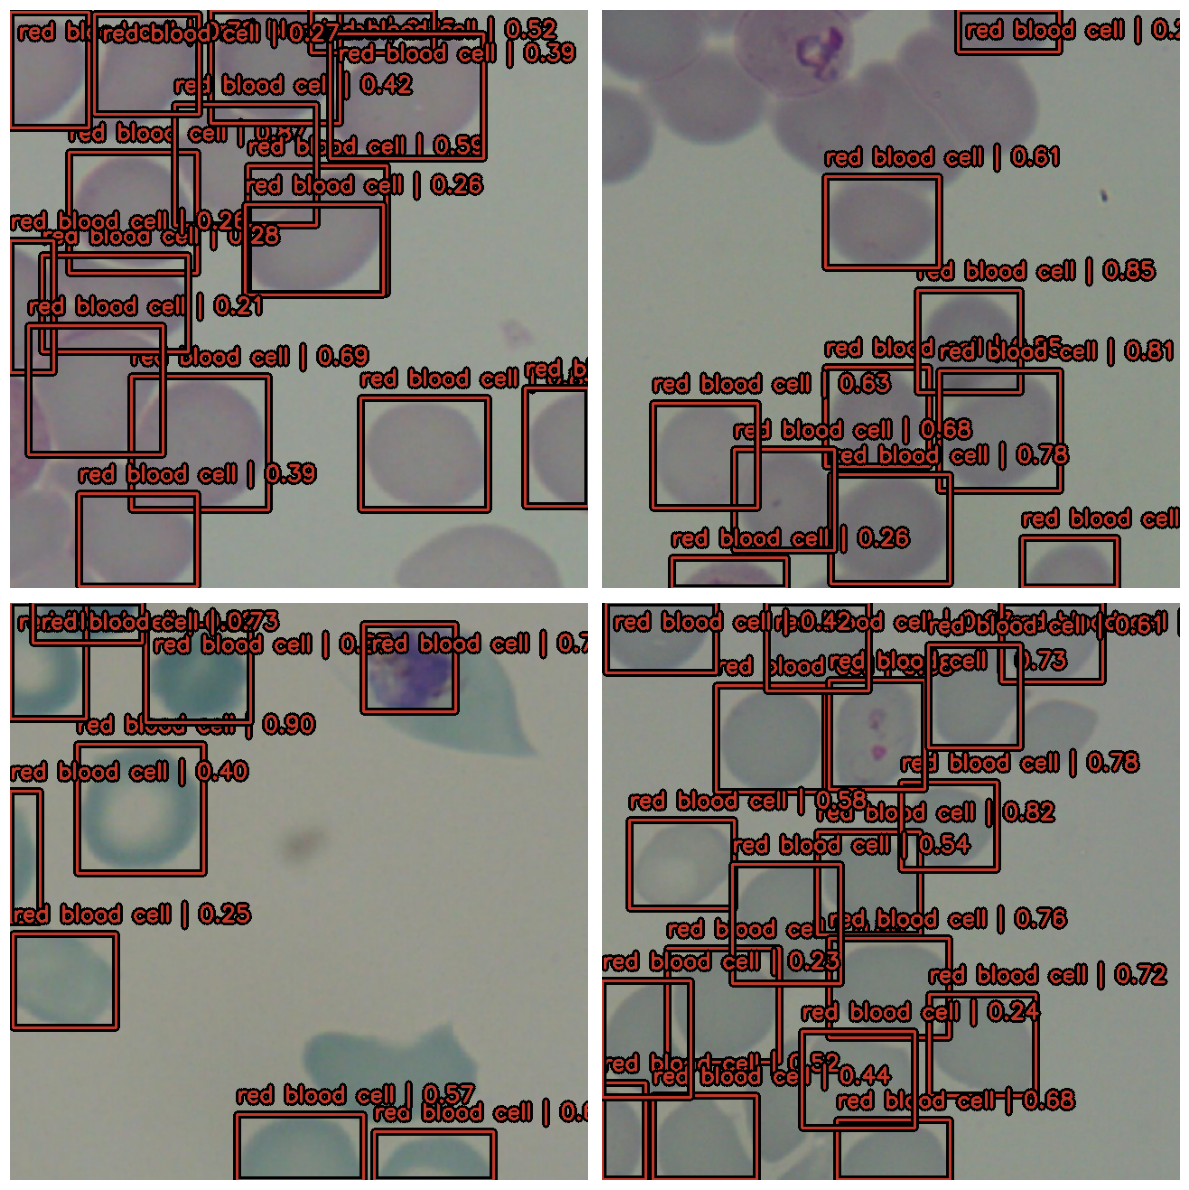

In [42]:
pred_visualizer(yoloV8,test_data, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)